# (2025) Graded Exercise 2: Simplified Computed Tomography

## Please write your name and student ID here: YOOJIN Kim (402772)

#### For submission, make sure to save your notebook with valid outputs for grading. Do not leave a lot of confusing debug output in your cells. 

**100 points** in total.

Since we attempt to use only the simple techniques, results may not always be perfect.

There are a total of **14 questions**, each marked with **TODO** for easy reference.

In [1]:
# Uncomment and run the code below in case you have library issues
# %pip install numpy==2.2.4
# %pip install matplotlib==3.10.1
# %pip install scipy==1.15.2
# %pip install scikit-image==0.25.2

In [2]:
from typing import List

import numpy as np
import numpy.typing as npt
import skimage
%matplotlib inline
import matplotlib.pyplot as plt

from assets.utils import grid_sample, normalize_0_1

# CONSTANTS, DO NOT CHANGE
SRC_IMAGE = np.load("assets/simple_pattern.npy")
ANGLE_RANGE = 180
ANGLE_STEP = 1
full_angle_list = [a for a in range(0, ANGLE_RANGE, ANGLE_STEP)]

## Background

In the course, we have explored various shape-from-X techniques which aim to reconstruct 3D surfaces from 2D observations. In this exercise, we’ll experiment with **Computed Tomography (CT)**.

CT recovers structures by measuring transmitted X-rays from multiple angles. This makes CT uniquely powerful for visualizing the inside of objects, not just their surfaces. The diagrams below illustrate the two main steps of CT:

<div style="text-align: center;">
    <img src="assets/forward_projection.png" alt="Forward Scheme from Smith Steven W" width="25%" style="padding-right: 100px;"/>
    <img src="assets/back_projection.png" alt="Back Scheme from Smith Steven W" width="25%"/>
</div>

- *Left - forward projection*: Project the sample onto a detector from various angles / views.
- *Right - reconstruction*: Reconstruct the sample using the multi-angle (multi-view) projections. 

In this exercise, you’ll implement CT **forward projection** and explore **three simple reconstruction methods** in 2D.

## Forward Projection

We simplify the forward projection operation to line integrals of the target sample (2D image) at specified angles. This process can be broken down into two steps:
1. Rotate the image to the desired angle (e.g. $0^\circ \sim 180^\circ $).
2. Perform line integration along y axis on the *rotated* image to generate a projection.

### Step 1: Rotate the image

In [3]:
from skimage.transform import rotate
rotate_img = lambda image, angle: rotate(image, angle)

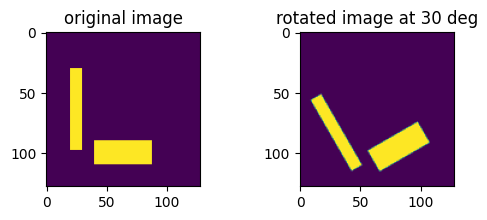

In [4]:
test_angle = 30
rotated_image = rotate_img(SRC_IMAGE, test_angle)

f, axarr = plt.subplots(1, 2, figsize=(6, 12))
f.set_figheight(2)
axarr[0].imshow(SRC_IMAGE)
axarr[0].set_title('original image')
axarr[1].imshow(rotated_image)
axarr[1].set_title(f'rotated image at {test_angle} deg')
plt.show()

### Step 2: Project the rotated image (5 points)

In [5]:
def project(img: npt.NDArray, angle: int)-> npt.NDArray:
    """
    Project the image at the given angle.

    Args:
        img (NDArray[float]): target 2D image of shape (H,W).
        angle (int): the angle to rotate the image.

    Returns:
       1D projection.
    """
    rotated_image = rotate_img(img, angle)

    # TODO: Calculate the projection (line integration) of the rotated image.
    # Hints: 
    #     - in discrete case, integration is sum.
    #     - integrate along Y axis (axis = 0)
    integration = np.sum(rotated_image, axis=0)

    return integration

Run the cell below to verify that your implementation works as expected.

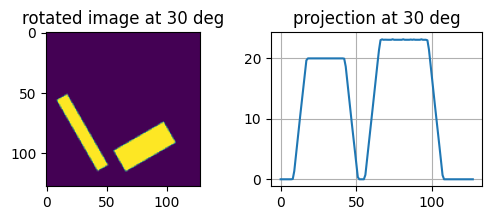

In [6]:
test_angle = 30
rotated_image = rotate_img(SRC_IMAGE, test_angle)
projected = project(SRC_IMAGE, test_angle)

f, axarr = plt.subplots(1, 2, figsize=(6, 12))
f.set_figheight(2)
axarr[0].imshow(rotated_image)
axarr[0].set_title(f'rotated image at {test_angle} deg')
axarr[1].plot(projected)
axarr[1].grid()
axarr[1].set_title(f'projection at {test_angle} deg')
plt.show()

### A compact structure: sinogram
With the function above, you can obtain projections from all the necessary angles, which are sufficient for reconstruction. However, in practice, researchers typically stack these 1D projections into a 2D image called a **sinogram**, where each **row** represents the projection at a specific angle:
<div style="text-align: center;">
    <img src="assets/projections_to_sinogram.jpg" alt="sinogram from projections [radiologykey]" width="40%" style="padding-right: 100px;"/>

This format makes it easier to visualize and detect errors or inconsistencies in the projection data.

**Question (5 points):** If the projections at certain angles are unexpectedly shifted, how would this affect the sinogram?
(Hint: Consider specific cases—for example, the projection at $30^\circ$ shifts to the left, while the one at $31^\circ$ shifts to the right-how does the sinogram change?)

**Answer:** The sinogram will show inter-row inconsistencies, such as horizontal glitches or blurrs.

**Question (10 points):** What other types of errors can be easily detected using a sinogram, and how can they be identified?

Hint: In practice, projections are measured by a detector that may:
- Fail completely at certain angles, returning all-zero projections.
- Contain faulty detector elements that always return zero, regardless of the angle.

How would these issues appear in the sinogram?

**Answer:** 
1. Full-zero rows will appear in the sinogram at angles where the detector fails completely.
2. Full-zero columns will appear in the sinogram corresponding to detector elements that are non-functional across all angles.

In additional to using sinogram as a diagnostic tool, it is one of the format that is supported by many algorithms. So, let's visualize the sinogram of our sample image.

In [7]:
def forward_project(img: npt.NDArray, angles_list: List[int]) -> npt.NDArray:
    """
    Forward project the image at given angles to obtain corresponding sinogram.

    Args:
        img (NDArray[float]): target 2D image of shape (H,W).
        angles_list (List[int]): the angles to rotate the image.

    Returns:
       sinogram.
    """
    H, W = img.shape

    projection_list = []
    # TODO: project the image at all angles (5 points)
    for angle in angles_list:
        projection = project(img, angle)
        projection_list.append(projection)

    return np.stack(projection_list)

Run the cell below to verify that your implementation works as expected.

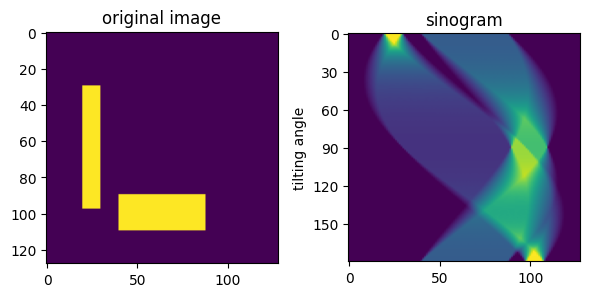

In [8]:
sinogram = forward_project(SRC_IMAGE, full_angle_list)
f, axarr = plt.subplots(1, 2, figsize=(6, 12))
axarr[0].imshow(SRC_IMAGE)
axarr[0].set_title('original image')
axarr[1].imshow(sinogram, aspect=0.7)
axarr[1].set_yticks(np.arange(0, len(full_angle_list), step = 30), full_angle_list[::30])
axarr[1].set_ylabel("tilting angle")
axarr[1].set_title(f'sinogram')
f.tight_layout()
plt.show()

## Back Projection

To reconstruct an image from its sinogram, a straightforward approach is to project the sinogram from each angle back onto the image—a process known as backprojection (see the right image in the Background section). This can be simplified into three steps:
1. For the projection at a given angle, backproject (or “smear”) it onto a 2D image to get the partial reconstruction for that angle.
2. Rotate this partial reconstruction to "align" with its original acquisition angle.
3. Accumulate alinged partial reconstructions from all angles to obtain the final image.

### Step 1: Smear projection (5 points)

In [9]:
def smear(projection: npt.NDArray) -> npt.NDArray:
    """
    Smear 1D projection on 2D image.
    
    Args:
        projection (NDArray[float]): 1D projection at the given angle.

    Returns:
       Square partial 2D reconstruction.
    """
    L = projection.shape[0]
    #print(projection.shape)
    # TODO: Smear the 1D projection on 2D image
    # Hint: 
    #     - smearing 1D projection on 2D equals to repeating the 1D array to fullfill the 2D array
    #     - np.repeat can be used for this purpose.
    #     - smear 1D projection along Y axis
    #     - first extend 1D projection to 1xN, then the returned array should have a shape of NxN
    #print(projection[np.newaxis, :].shape)
    recon_1_angle = np.repeat(projection[np.newaxis, :], L, axis=0)
    #print(recon_1_angle.shape)
    return recon_1_angle

Run the cell below to verify that your implementation works as expected.

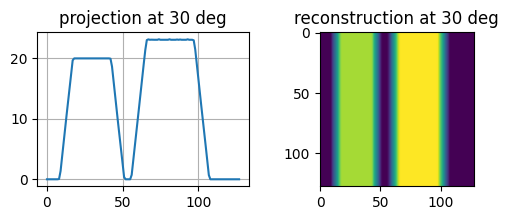

In [10]:
angle_idx =30

recon_1_angle = smear(sinogram[angle_idx])

f, axarr = plt.subplots(1, 2, figsize=(6, 12))
f.set_figheight(2)
axarr[0].plot(sinogram[angle_idx])
axarr[0].set_title(f'projection at {full_angle_list[angle_idx]} deg')
axarr[0].grid()
axarr[1].imshow(recon_1_angle)
axarr[1].set_title(f'reconstruction at {full_angle_list[angle_idx]} deg')
plt.show()

### Step 2: Rotate and accumulate smeared projections (5 points)

In [11]:
def back_project(sinogram: npt.NDArray, angles_list: List[int]) -> npt.NDArray:
    """
    Back project sinogram to reconstruct the image.

    Args:
        sinogram (NDArray[float]): the measured sinogram with a shapr of [A, W]. 
                                   A is the number of angles and W is the length of 1D projections.
        angles_list (List[int]): the list of angles generating the given sinogram, from 0 to 180.

    Returns:
        reconstructed image.
    """

    A, L = sinogram.shape
    assert A == len(angles_list)

    image = np.zeros([L, L])
    for idx, angle in enumerate(angles_list):

        # TODO: For each projection in the sinogram, smear it to obtain its 2D partial reconstruction.
        # Then, rotate this reconstruction to align with its original acquisition angle. 
        # Finally, accumulate aligned partial reconstructions from all angles to obtain the final image.
        # Hints: 
        #     - when rotate partial reconstructions, THINK CAREFULLY what should be the angle.
        #     - you can use the rotate_img and smear functions
        
        recon_1_angle = smear(sinogram[idx])
        recon_rotated = rotate_img(recon_1_angle, -angle) # THINK CAREFULLY what should be the angle!
        image = image + recon_rotated

    return image


Run the cell below to verify that your implementation works as expected.

**Hint**: Your reconstruction should have the **same orientation** as the 
      original image. If it appears rotated or flipped, reconsider the 
      angle used in `recon_rotated = ...` above.

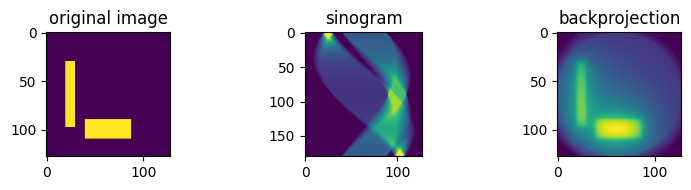

In [12]:
from IPython.display import Markdown, display
HINTSTR = "**Hint**: Your reconstruction should have the **same orientation** as the \n" + \
          "      original image. If it appears rotated or flipped, reconsider the \n" + \
          "      angle used in `recon_rotated = ...` above."
display(Markdown(HINTSTR))

bp_recon = back_project(sinogram, full_angle_list)
f, axarr = plt.subplots(1, 3, figsize=(8, 16))
f.set_figheight(2)
axarr[0].imshow(SRC_IMAGE)
axarr[0].set_title('original image')
axarr[1].imshow(sinogram, aspect=0.75)
axarr[1].set_title(f'sinogram')
axarr[2].imshow(bp_recon)
axarr[2].set_title(f'backprojection')
f.tight_layout()
plt.show()

**Question (10 points):** What artifacts do you observe in the backprojection reconstruction? 

**Answer:** The reconstruction contains a circular artifact that is not present in the original image, and it appears blurred.

## Filtered Back Projection (FBP)  (15 points)
Some of the artifacts arise from the accumulation step in the backprojection process, which tends to amplify low-frequency components. To reduce this artifact, we can use a high-pass filter to suppress low frequencies and enhance high frequencies. 

Specifically, let $g_i$ represent the $i$-th row of the sinogram. The *Filtered Backprojection (FBP)* process can be broken down into the following steps:
1. Define a simple high-pass filter: $ F_{HP}(s) = | s |$.
2. Transform $g_i$ into frequency domain: $G_i = \mathcal{F}(g_i)$, where $\mathcal{F}$ represents the Fourier transform and can be done using np.fft.rfft($g_i$).
3. Apply the filter to enhance high-frequency components: $G'_i = F_{HP} \cdot G_i$. Here, the $\cdot$ means element-wise product.
4. Transform back to the spatial domain to obtain the filtered projection: $g'_i = \mathcal{F}^{-1}(G'_i)$. This can be done using np.fft.irfft($G'_i$).
5. Perform backprojection using the filtered projection $g'_i$.


In [13]:
def filtered_back_project(sinogram: npt.NDArray, angles_list: List[int]) -> npt.NDArray:
    """
    Use filtered back projection to reconstruct the image.

    Args:
        sinogram (NDArray[float]): the measured sinogram with a shapr of [A, W]. 
                                   A is the number of angles and W is the size of projections.
        angles_list (List[int]): the list of angles generating the given sinogram.

    Returns:
        reconstructed image.
    """

    A, L = sinogram.shape
    assert A == len(angles_list)

    # Define the ramp filter in frequency space.
    F_HP = np.arange(0, L // 2 + 0.1)

    image = np.zeros([L, L])
    for idx, angle in enumerate(angles_list):

        # TODO (10 points): For each projection, filter it with the provided high-pass filter, 
        #                   following the steps described above.
        gi = sinogram[idx]
        Gi = np.fft.rfft(gi)
        Gi_prime = F_HP * Gi
        gi_prime = np.fft.irfft(Gi_prime)

        # TODO(5 points): Perform backprojection using the filtered projection gi_prime.
        recon_1_angle = smear(gi_prime)
        recon_rotated = rotate_img(recon_1_angle, -angle)
        image = image + recon_rotated

    return image

Run the cell below to verify that your implementation works as expected.

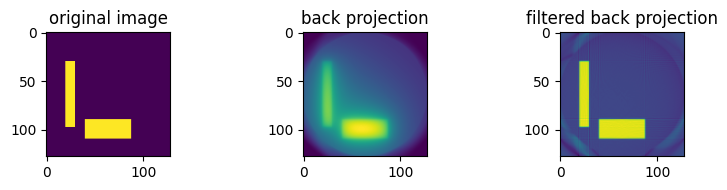

In [14]:
fbp_recon = filtered_back_project(sinogram, full_angle_list)
f, axarr = plt.subplots(1, 3, figsize=(8, 16))
f.set_figheight(2)
axarr[0].imshow(SRC_IMAGE)
axarr[0].set_title(f'original image')
axarr[1].imshow(bp_recon)
axarr[1].set_title(f'back projection')
axarr[2].imshow(fbp_recon)
axarr[2].set_title(f'filtered back projection')
f.tight_layout()
plt.show()

**Question (5 points):** Is the FBP reconstruction better than that of simple backprojection? Does it perfectly match the original image?

**Answer:** Yes. The FBP reconstruction resulted better with clearer edges of two rectangles comparing to the simple backprojection. The location of rectangles seems to match well with the original image, but still does not perfectly match the original image.

## Simultaneous Algebraic Reconstruction Technique (SART) (10 points)
In addition to one-shot reconstruction methods, there are many iterative techniques that refine an initial reconstruction step-by-step to achive good quality. A common example is SART (Simultaneous Algebraic Reconstruction Technique), which we simplify here as follows:
1. Input: initial reconstruction $x_0$, measured sinogram $y$, maximum iterations $N$, and update weight $w$.
2. Forward project $x_i$ to obtain the estimated sinogram $y_i$.
3. Compute the residual error $\Delta y = y - y_i$.
4. Backproject $\Delta y$ to generate the error image $\Delta x$.
5. Update the reconstruction: $x_{i+1} = x_i + w \cdot \Delta x$.
6. Repeat steps 2–5 until the maximum number of iterations N is reached; return the final reconstruction $x_N$.

In [15]:
def SART(
    sinogram: npt.NDArray, angles_list: List[int], num_iters: int, w: float = 0.01
) -> npt.NDArray:
    """
    Use SART to reconsturct the image.

    Args:
        sinogram (NDArray[float]): the measured sinogram with a shapr of [A, W]. 
                                   A is the number of angles and W is the size of projections.
        angles_list (List[int]): the list of angles generating the given sinogram.
        num_iters (int): maximum number of optimzation iterations.
        w (float): weight to adjust updating step size.
    
    Returns:
        reconstructed image.
    """
    A, L = sinogram.shape
    assert A == len(angles_list)

    try:
        x_0 = filtered_back_project(sinogram, angles_list)
    except:
        print("FBP not working, use BP instead for SART initial reconstruction.")
        x_0 = back_project(sinogram, angles_list)
        
    x_0 = normalize_0_1(x_0) # Normalize initial reconstruction for stability

    x_i = x_0.copy()

    # TODO: Iterative optimization
    for i in range(num_iters):
        # Get estimated sinogram
        y_i = forward_project(x_i, angles_list)

        # Calculate residual error in projections
        dy = sinogram - y_i

        # Project the error back to image
        dx = back_project(dy, angles_list)

        # For stability
        dx /= len(angles_list)

        # Update x_i
        x_i = x_i + w * dx

        # Force positivity
        x_i[x_i < 0] = 0

    return x_i

Run the cell below to verify that your implementation works as expected.

This could take ~5 sec ...


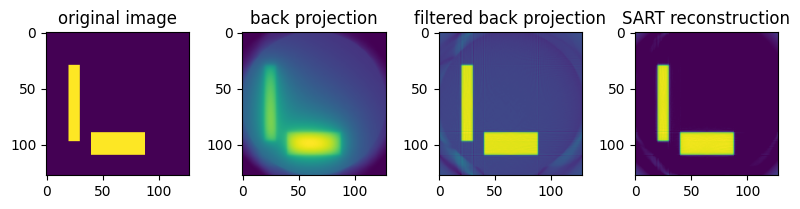

In [16]:
# You can start with a small num_iters for debugging. But to show the difference, set num_iters=30 would be better.

print("This could take ~5 sec ...")
sart_recon = SART(sinogram, full_angle_list, 30, w=0.01)
f, axarr = plt.subplots(1, 4, figsize=(8, 16))
f.set_figheight(2)
axarr[0].imshow(SRC_IMAGE)
axarr[0].set_title(f'original image')
axarr[1].imshow(bp_recon)
axarr[1].set_title(f'back projection')
try:
    axarr[2].set_title(f'filtered back projection')
    axarr[2].imshow(fbp_recon)
except: 
    pass
axarr[3].imshow(sart_recon)
axarr[3].set_title(f'SART reconstruction')
f.tight_layout()
plt.show()

**Question (5 points):** Which method produces the best reconstruction results?

**Answer:** The SART reconstruction produces the best result. It is almost perfectly reconstructed like the original image.

## Challenging Cases in Real Application

Although CT is widely used in medicine, materials science, and security screening due to its non-invasive nature, it comes with several limitations. For example, the radiation exposure can potentially harm healthy tissues, and CT scanners require a relatively large physical footprint. As a result, three common challenging scenarios have emerged: Low-Dose CT (LDCT), Limited-Angle CT (LACT), and Sparse-View CT (SVCT)—each of which can lead to degraded reconstruction quality.

In this final section, we will explore the effects of LACT and SVCT on reconstruction results.

### Limited-Angle CT (LACT)

Typical Limited-Angle CT (LACT) scenarios include *airport baggage scanners* and *dental CT systems*, where the design must balance speed, mechanical simplicity, and space constraints. In such cases, projections can only be acquired within a limited angular range, which restricts the information available for reconstruction.

The figures below show reconstruction results using BP, FBP, and SART under LACT conditions with varying angle ranges:

<div style="text-align: center;">
    <img src="assets/LACT_10deg.png" alt="Forward Scheme from Smith Steven W" width="40%" style="padding-right: 50px;"/>
    <img src="assets/LACT_30deg.png" alt="Back Scheme from Smith Steven W" width="40%"/>
</div>
<div style="text-align: center;">
    <img src="assets/LACT_90deg.png" alt="Forward Scheme from Smith Steven W" width="40%" style="padding-right: 50px;padding-top: 10px"/>
    <img src="assets/LACT_160deg.png" alt="Back Scheme from Smith Steven W" width="40%"/>
</div>


**Question (10 points):** Describe the degradation you observe in above figures and explain why it occurs in this way.
(If your codes work properly, run the cell below with different values for *angle_range* and observe how the reconstructions change. Your results should be the same as above figures for the specified angle range.)

**Answer:** The reconstruction becomes blurry and smoothed, especially at the corners which require a wider angular range for accurate reconstruction. Directional shadow-like artifacts appear in the image.
All reconstruction methods can only use projections within the available angular range. For corner regions that require rays from outside this range to reconstruct, the reconstruction only captures the components visible within the limited angles, leading to blurred and smootheded corners.
In full-angle CT, directional artifacts are canceled out due to the balanced contributions of rays from all directions. In contrast, in Limited-Angle CT (LACT), the absence of rays from certain angles creates an imbalance, resulting in directional shadow artifacts.

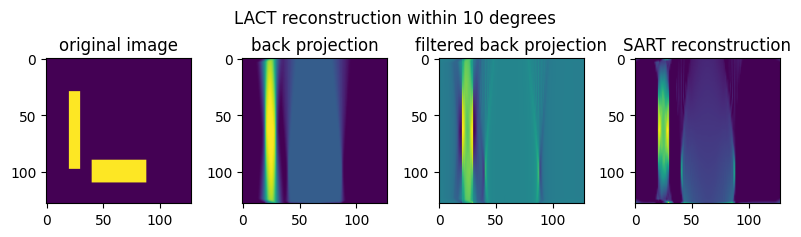

In [17]:
angle_range = 10 # Limited Angle CT
angle_step = 1

# To better vis the artifact, make angles symetric
angles_list = [a for a in range(-angle_range//2, angle_range//2, angle_step)] 
sinogram = forward_project(SRC_IMAGE, angles_list)

bp_recon = back_project(sinogram, angles_list)
fbp_recon = filtered_back_project(sinogram, angles_list)
sart_recon = SART(sinogram, angles_list, 30)

f, axarr = plt.subplots(1, 4, figsize=(8, 3))
axarr[0].imshow(SRC_IMAGE)
axarr[0].set_title(f'original image')
axarr[1].imshow(bp_recon)
axarr[1].set_title(f'back projection')
axarr[2].imshow(fbp_recon)
axarr[2].set_title(f'filtered back projection')
axarr[3].imshow(sart_recon)
axarr[3].set_title(f'SART reconstruction')
f.tight_layout()
f.subplots_adjust(top=1.1)
f.suptitle(f"LACT reconstruction within {angle_range} degrees")
plt.show()

### Sparse-View CT (SVCT)

The main purposes of using SVCT include reducing radiation exposure for vulnerable patient (e.g. children) and reducing scaning time for real-time monitoring. In these cases, only a few sparse angular projections are taken for reconstruction. The following figures show the reconstruction results of BP, FBP and SART in SVCT with different number of projections:
<div style="text-align: center;">
    <img src="assets/SVCT_36Views.png" alt="Forward Scheme from Smith Steven W" width="40%" style="padding-right: 50px;"/>
    <img src="assets/SVCT_18Views.png" alt="Back Scheme from Smith Steven W" width="40%"/>
</div>
<div style="text-align: center;">
    <img src="assets/SVCT_9Views.png" alt="Forward Scheme from Smith Steven W" width="40%" style="padding-right: 50px;padding-top: 10px"/>
    <img src="assets/SVCT_4Views.png" alt="Forward Scheme from Smith Steven W" width="40%"/>
</div>


**Question (10 points):** Describe the degradation you observe in SVCT and explain why it occurs in this way.
(Hint: If your codes work properly, run the cell below with different values for *angle_step* and observe how the reconstructions change. Your results should be the same as above figures for the specified number of projections.)

**Answer:** The reconstruction shows directional and structural artifacts and appears less continuous. In some cases, e.g. angle_step = 40, the reconstruced horizontal square appears tilted.
In the case of sparse-view CT, although the full angular range (e.g., $180^\circ$) is covered, only a limited number of projections are available. Each sparse projection is smeared into the 2D image as a straight-line contribution. When these are accumulated, they fail to fully capture the object’s structure, resulting in directional streaks and structural distortions in the reconstructed image.
In the case like angle_step = 40, the projection angles are unevenly distributed: three of the views span angles less than $90^\circ$, while only one view covers an angle greater than $180^\circ$. This imbalance in angular coverage leads to directional bias in the reconstruction, resulting in the observed tilt.

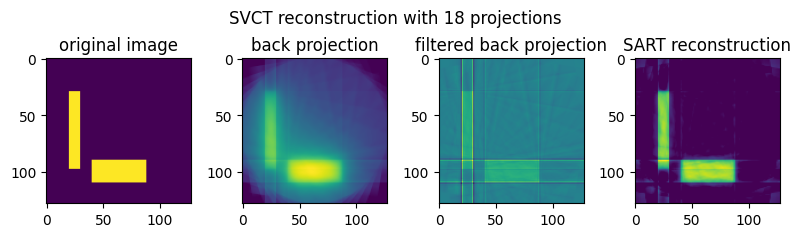

In [18]:
angle_range = 180
angle_step = 10  # Sparse View CT

# To better vis the artifact, make angles symetric
angles_list = angles_list = [a for a in range(0, angle_range, angle_step)]
sinogram = forward_project(SRC_IMAGE, angles_list)

bp_recon = back_project(sinogram, angles_list)
fbp_recon = filtered_back_project(sinogram, angles_list)
sart_recon = SART(sinogram, angles_list, 30)

f, axarr = plt.subplots(1, 4, figsize=(8, 3))
axarr[0].imshow(SRC_IMAGE)
axarr[0].set_title(f'original image')
axarr[1].imshow(bp_recon)
axarr[1].set_title(f'back projection')
axarr[2].imshow(fbp_recon)
axarr[2].set_title(f'filtered back projection')
axarr[3].imshow(sart_recon)
axarr[3].set_title(f'SART reconstruction')
f.tight_layout()
f.subplots_adjust(top=1.1)
f.suptitle(f"SVCT reconstruction with {angle_range // angle_step} projections")
plt.show()

---

---